Import Libraries

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import csv
from sklearn import svm
import pandas as pd
import itertools
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split


Define the constants and initial conditions

In [2]:
length = 1e-2             # Length of the rod


# Material properties

rho_l = 2760.0                # Density of Aluminium (kg/m^3) in liquid state
rho_m = 2760.0                # Density of Aluminium (kg/m^3) in mushy state
rho_s = 2760.0               # Density of Aluminium (kg/m^3) in solid state
k_m =     109.0                 # W/m-K Thermal Conductivity inMushy zone
k_l =     109.0                   # W/m-K Thermal Conductivity in Liquid zone
k_s =     109.0                  # W/m-K Thermal Conductivity in Solid zone
cp_m =     963.0                  # Specific heat of aluminum (J/kg-K) in mushy zone
cp_l =    963.0                   # Specific heat of aluminum (J/kg-K) in liquid zone
cp_s =      963.0                  # Specific heat of aluminum (J/kg-K)  in solid zone
alpha_m = k_m / (rho_m * cp_m)            # Thermal diffusivity 
alpha_l = k_l / (rho_l * cp_l)    # Thermal diffusivity of liquid phase
alpha_s = k_s / (rho_s * cp_s)    # Thermal diffusivity of solid phase
# print(alpha_m)
# print(alpha_l)
# print(alpha_s)
#L_fusion = 3.9e3                 # J/kg
L_frz = 389.0e3             # J/kg


# Initial and boundary Conditions
T_L = 866.0                       #  K -Liquidus Temperature (593 c)
T_S = 811.0                       # K- Solidus Temperature (538 C)



# Spatial discretization
num_points = 50               # Number of spatial points
dx = length / (num_points - 1)
print('dx is',dx)

                                                              
# Time Discretization  
time_end = 20             # seconds                         


# cr1  = (np.max([alpha_l,alpha_m, (k_m/rho_m*(cp_m-(L_frz/(T_L-T_S))))]))
cr2 = alpha_m
#print('cr1 is',cr1)
dt = abs(0.5 *(dx**2/cr2))
num_steps = round(time_end/dt) +1
#print('dt is ',dt)
#num_steps = 1000
#dt = time_end/num_steps
# print('num_steps is',num_steps)


cfl = abs(0.5 *(dx**2/cr2))
print('cfl is',cfl)
#dt = time_end / num_steps
time_steps = np.linspace(0, time_end, num_steps + 1)

if dt <= cfl:
    print('stability criteria satisfied')
else:
    print('stability criteria not satisfied')
    sys.exit()

dx is 0.00020408163265306123
cfl is 5.0779300673648986e-05
stability criteria satisfied


Defining the simulation field and initilisation of the temperatures

In [4]:
# Initial temperature and phase fields
temperature = np.full(num_points, 870.0)
phase = np.zeros(num_points)*1.0

# Set boundary conditions
temperature[-1] = 313.0 #(40 C)
phase[-1] = 1

temperature[0] = 313.0 #(40 C)
phase[0] = 1


# Store initial state in history
temperature_history = [temperature.copy()]
phi_history = [phase.copy()]

#print(temperature_history,phi_history)

Solving the heat transfer equation and phase change using numerical methods

In [5]:
# Finite difference method

for m in range(1, num_steps+1):                  # time loop
                # space loop, adjusted range
        
    temp_n = temperature[1:num_points-1]
    #print('temp_n is',temp_n)
    c1_val = np.maximum(temp_n - T_L,0) / np.where(temp_n- T_L!=0, temp_n - T_L, 1)
    c1_val = np.where(c1_val == 0, 0, c1_val)
    #print('c1_val is',c1_val)   
    c2_val = np.maximum(T_S - temp_n,0) / np.where(T_S - temp_n!=0, T_S - temp_n, 1)
    c2_val = np.where(c2_val == 0, 0, c2_val)
    #print('c2_val is',c2_val)
    c3_val = (1-c1_val)*(1-c2_val)
    c3_val = np.where(c3_val == 0, 0, c3_val)
    #print('c3_val is',c3_val) 
    #d2T_dx2 = (temperature[2:num_points] - 2*temp_n + temperature[0:num_points-2]) / dx**2
    phu = (c1_val*alpha_l)+(c2_val*alpha_s)+(c3_val*(k_m/(rho_m*(cp_m-(L_frz/(T_L-T_S))))))
    temperature[1:num_points-1] += phu * (dt / dx**2)* (temperature[2:num_points] - 2*temp_n + temperature[0:num_points-2]) 
    phase[1:num_points-1] = np.clip((T_L - temp_n)/(T_L-T_S),0,1)
    
    #print(f" time{m},Temperature: {temperature}, ")
    temperature_history.append(np.round(temperature.copy(),3))
    phi_history.append(np.round(phase.copy(),3))
    #Print for debugging
    


#print(temperature_history)
#print(phi_history)


# there is an error in this code and it is due to the constants mismatch  and not a calcualtion error

Plot the Results

Temperature History Shape: (393863, 50)
Phi History Shape: (393863, 50)
Transposed Temperature History Shape: (393863, 50)
Transposed Phi History Shape: (393863, 50)


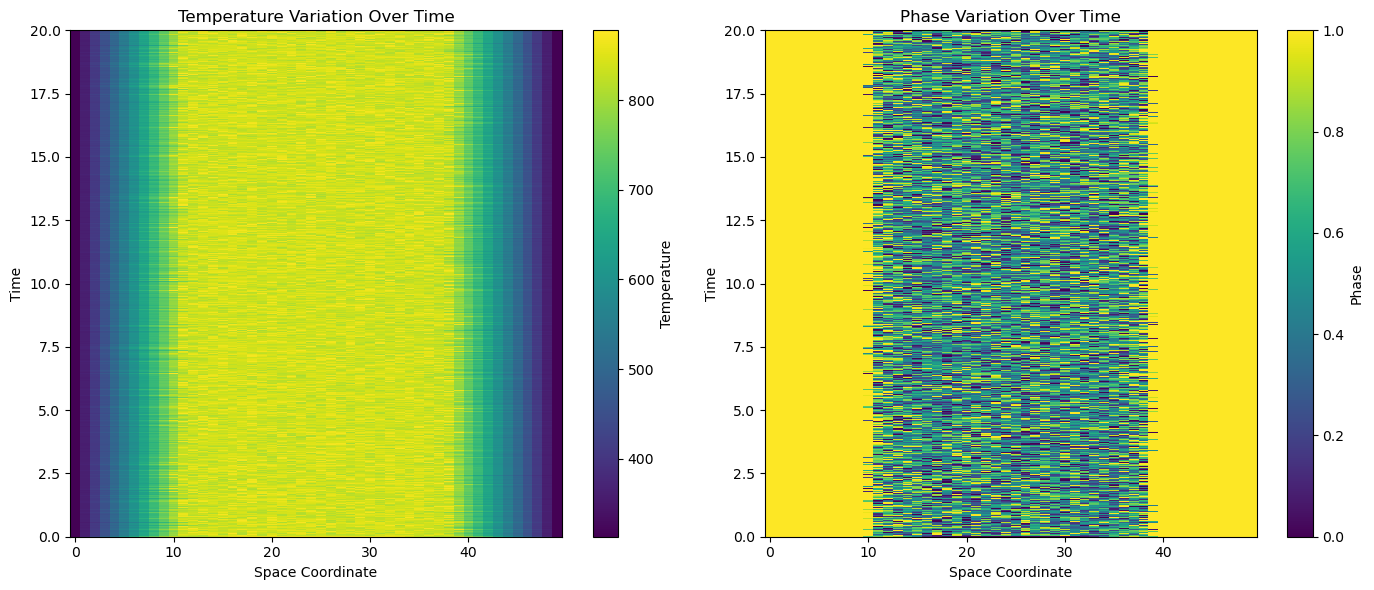

In [6]:
# Assuming you have temperature_history and phi_history as lists of arrays
temperature_history = np.array(temperature_history)
phi_history = np.array(phi_history)

# Check the shape of temperature_history and phi_history
print("Temperature History Shape:", temperature_history.shape)
print("Phi History Shape:", phi_history.shape)

# Check the new shape after transposing
print("Transposed Temperature History Shape:", temperature_history.shape)
print("Transposed Phi History Shape:", phi_history.shape)

# Create a meshgrid for space and time coordinates
space_coord, time_coord = np.meshgrid(np.arange(temperature_history.shape[1]), np.arange(temperature_history.shape[0]))
time_coord = time_coord * dt
# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot the temperature history on the left subplot
im1 = ax1.pcolormesh(space_coord, time_coord, temperature_history, cmap='viridis')
ax1.set_xlabel('Space Coordinate')
ax1.set_ylabel('Time')
ax1.set_title('Temperature Variation Over Time')
fig.colorbar(im1, ax=ax1, label='Temperature')

# Plot the phase history on the right subplot
im2 = ax2.pcolormesh(space_coord, time_coord, phi_history, cmap='viridis')
ax2.set_xlabel('Space Coordinate')
ax2.set_ylabel('Time')
ax2.set_title('Phase Variation Over Time')
fig.colorbar(im2, ax=ax2, label='Phase')
plt.tight_layout()
plt.show()